<a href="https://colab.research.google.com/github/fischsauce/Image-Classifier/blob/master/Stock_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame

import numpy as np
from sklearn import linear_model
from sklearn.linear_model import Ridge
from matplotlib import style

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Reticulating splines...
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Import TESLA stock history for the past 3 years:
start = datetime.datetime(2016, 9, 8)
end = datetime.datetime(2019, 9, 9)
df_original = web.DataReader("TSLA", 'yahoo', start, end)

df_original = df_original.reset_index()
df_original.set_index('Date', inplace=True, drop=True)

# Display incoming transmission:
df_original.head()

#print(df_original)



,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2016-09-08,199.889999,196.360001,199.550003,197.360001,3370000,197.360001
2016-09-09,199.919998,193.699997,199.089996,194.470001,3757000,194.470001
2016-09-12,201.369995,194.100006,195.000000,198.300003,3715200,198.300003
2016-09-13,198.490005,193.449997,197.059998,196.050003,3589400,196.050003
2016-09-14,197.919998,194.860001,195.750000,196.410004,2254500,196.410004


755


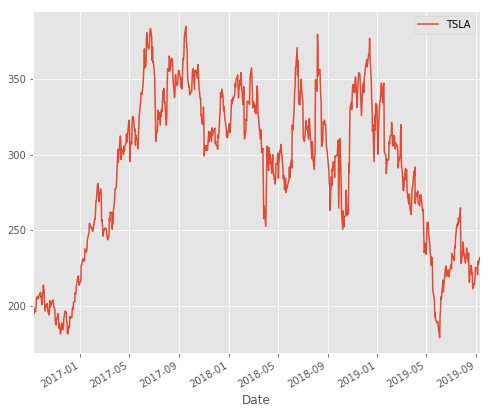

In [19]:
# Adjusting the style of matplotlib
style.use('ggplot')

# Making a copy of the df seems like common practice:
df = df_original.copy()

# Get me a visual on this:
df['Close'].plot(label='TSLA')
plt.legend()
print (len(df.index))

# Notes:

**I want to make use of as much of this data as I can, here's my initial thoughts on feature sets:**
 

  *NB: For the sake of these notes, we are trying to predict the price on Monday (Mon)*

## Feature A 
**The previous weeks's closing prices (5 days)**

  A.1 = Mon

  A.2 = Tue

  A.3 = Wed

  A.4 = Thu

  A.5 = Fri


## Feature B. 
**The previous day's volatility**

  One way could be to simply find the variance between daily high and low:

  B.1 = High(Fri) - Low(Fri)

  B.2 = High(Thu) - Low(Thu)

  B.3 = High(Wed) - Low(Wed)

...

  *And then average out the previous 3 days' volatility:*

...

  B.4 = (B.1 + B.2 + B.3) / 3


## Feature C. 
**Two-Week Moving average (10 days).**

  C = Adj Close(Mon to Friday x 2 weeks) / 10 days


## Feature D. 
**There's probably some value in looking at the previous day's close vs next day's opening price:**

*** It should give a rough indication of positive or negative sentiment between two days.**

  D = Open(Mon) - Close(Fri)
  

In [7]:
# Feature A. -- Previous weeks's closing prices --

df = df_original.copy()

weekly_window = 5
weekly_iterations = len(df) - weekly_window
weekly_indices = np.arange(weekly_iterations).astype(np.int)[:,None] + np.arange(weekly_window + 1).astype(np.int)

weekly_data = df['Close'].values[weekly_indices]

X_weekly = weekly_data[:,:-1]
Y_weekly = weekly_data[:,-1]

X_weekly.shape

(750, 5)

In [9]:
# Feature B. -- Previous day's volatility --

df = df_original.copy()

volatility_window = 3
volatility_iterations = len(df) - volatility_window
volatility_indices = np.arange(volatility_iterations).astype(np.int)[:,None] + np.arange(volatility_window + 1).astype(np.int)

volatility_data = df['High'].values[volatility_indices] - df['Low'].values[volatility_indices]

X_volatility = volatility_data[:,:-1]
Y_volatility = volatility_data[:,-1]

X_volatility.shape
#X_volatility

(752, 3)

In [101]:
# Feature C. -- Two-Week Moving average (10 days) --

df = df_original.copy()

mav_window = 10
mav_iterations = len(df) - mav_window
mav_indices = np.arange(mav_iterations).astype(np.int)[:,None] + np.arange(mav_window + 1).astype(np.int)

mav_data = df['Close'].values[mav_indices]
X_mav = (mav_data[:,:-1]).sum(axis=1, keepdims = True) / mav_window
Y_mav = mav_data[:,-1]

#X_mav.reshape(-1, 1)
X_mav.shape
#mav_data.shape

#Y_mav.shape

(745, 1)

In [11]:
# Feature D. -- Previous day's Close VS today's Opening price --
# (queued trades while market was closed)

df = df_original.copy()

pretrades_window = 1
pretrades_iterations = len(df) - pretrades_window
pretrades_indices = np.arange(pretrades_iterations).astype(np.int)[:,None] + np.arange(pretrades_window).astype(np.int)

X_pretrades = df['Open'].values[pretrades_indices +1] - df['Close'].values[pretrades_indices]
Y_pretrades = pretrades_indices[:,-1]

#Y_pretrades.shape
#print(pretrades_data)
X_pretrades.shape

(754, 1)

In [0]:
## Thanks to Manny Bernabe for passing on this helper function! :D

from sklearn import metrics

# (The point is to get a baseline for comparing our models)
def get_performance (model_pred, y__test):
  print('Mean Absolute Error:', metrics.mean_absolute_error(y__test, model_pred).round(4))  
  print('Mean Squared Error:', metrics.mean_squared_error(y__test, model_pred).round(4))  
  print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y__test, model_pred)).round(4))
  
def get_plot (model_pred, y__test):
  plt.scatter(model_pred, y__test, color="gray")
  plt.plot(y__test, y__test, color='red', linewidth=2)

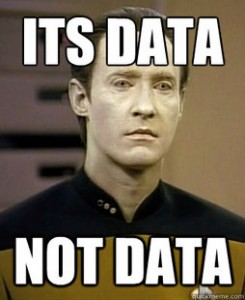

In [53]:
# Split the Datas:

from IPython.display import Image
Image('./datanotdata.jpg')

In [0]:
split_fraction = 0.60

df = df_original.copy()

weekly_split = int(split_fraction * weekly_iterations)
volatility_split = int(split_fraction * volatility_iterations)
mav_split = int(split_fraction * mav_iterations)
pretrades_split = int(split_fraction * pretrades_iterations)

In [21]:
# Establish baseline metrics:

df = df_original.copy()

base_window = 5
base_iterations = len(df) - base_window
base_indices = np.arange(base_iterations).astype(np.int)[:,None] + np.arange(base_window + 1).astype(np.int)

base_data = df['Close'].values[base_indices]
base_split = int(split_fraction * base_iterations)

X_base = base_data[:,:-1]
Y_base = base_data[:,-1]

x_train_base = X_base[:base_split]
y_train_base = Y_base[:base_split]
x_test_base = X_base[base_split:]
y_test_base = Y_base[base_split:]

y_pred_lag = np.roll(y_test_base,1)
get_performance(y_pred_lag, y_test_base)

Mean Absolute Error: 7.4363
Mean Squared Error: 151.0722
Root Mean Squared Error: 12.2911


In [22]:
## Compare Feature A to the baseline:

x_train_weekly = X_weekly[:weekly_split]
y_train_weekly = Y_weekly[:weekly_split]

x_test_weekly = X_weekly[weekly_split:]
y_test_weekly = Y_weekly[weekly_split:]

# A.1 Linear Regression
model_lr_weekly = linear_model.LinearRegression()
model_lr_weekly.fit(x_train_weekly, y_train_weekly)

y_pred_lr_weekly = model_lr_weekly.predict(x_test_weekly)
get_performance(y_pred_lr_weekly, y_test_weekly)

Mean Absolute Error: 7.1433
Mean Squared Error: 110.157
Root Mean Squared Error: 10.4956


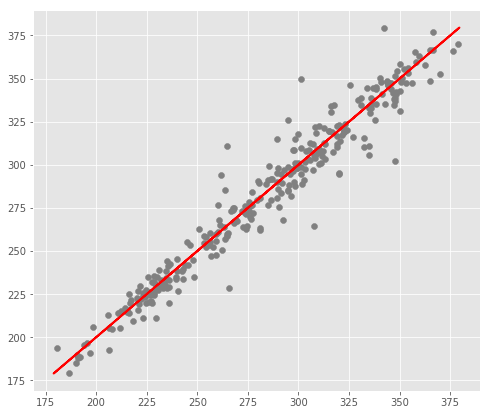

In [25]:
get_plot(y_pred_lr_weekly, y_test_weekly)

In [26]:
# A.2 Ridge
model_ridge_weekly = linear_model.Ridge()
model_ridge_weekly.fit(x_train_weekly, y_train_weekly)

y_pred_ridge_weekly = model_ridge_weekly.predict(x_test_weekly)
get_performance(y_pred_ridge_weekly, y_test_weekly)

Mean Absolute Error: 7.1433
Mean Squared Error: 110.1559
Root Mean Squared Error: 10.4955


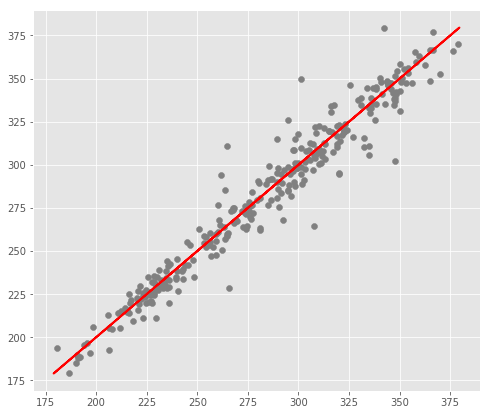

In [27]:
get_plot(y_pred_ridge_weekly, y_test_weekly)

In [28]:
# A.3 Lassooo
model_lasso_weekly = linear_model.Lasso()
model_lasso_weekly.fit(x_train_weekly, y_train_weekly)

y_pred_lasso_weekly = model_lasso_weekly.predict(x_test_weekly)
get_performance(y_pred_lasso_weekly, y_test_weekly)

Mean Absolute Error: 7.1089
Mean Squared Error: 109.6887
Root Mean Squared Error: 10.4732


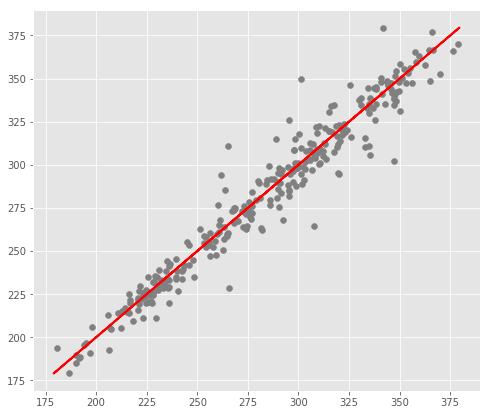

In [29]:
get_plot(y_pred_lasso_weekly, y_test_weekly)

In [30]:
## Compare Feature B to the baseline:

x_train_volatility = X_volatility[:volatility_split]
y_train_volatility = Y_volatility[:volatility_split]

x_test_volatility = X_volatility[volatility_split:]
y_test_volatility = Y_volatility[volatility_split:]

# B.1 Linear Regression
model_lr_volatility = linear_model.LinearRegression()
model_lr_volatility.fit(x_train_volatility, y_train_volatility)

y_pred_lr_volatility = model_lr_volatility.predict(x_test_volatility)
get_performance(y_pred_lr_volatility, y_test_volatility)


Mean Absolute Error: 3.1486
Mean Squared Error: 24.3186
Root Mean Squared Error: 4.9314


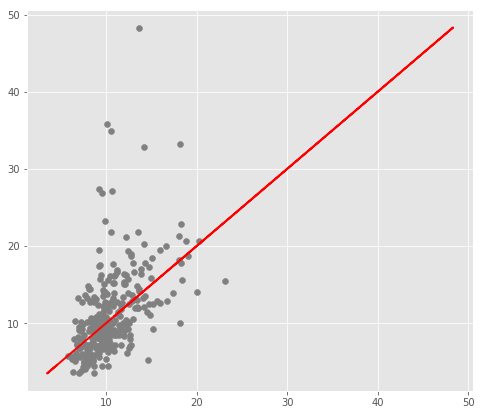

In [31]:
get_plot(y_pred_lr_volatility, y_test_volatility)

In [32]:
# B.2 Ridge Regression
model_ridge_volatility = linear_model.Ridge()
model_ridge_volatility.fit(x_train_volatility, y_train_volatility)

y_pred_ridge_volatility = model_ridge_volatility.predict(x_test_volatility)
get_performance(y_pred_ridge_volatility, y_test_volatility)

Mean Absolute Error: 3.1486
Mean Squared Error: 24.3187
Root Mean Squared Error: 4.9314


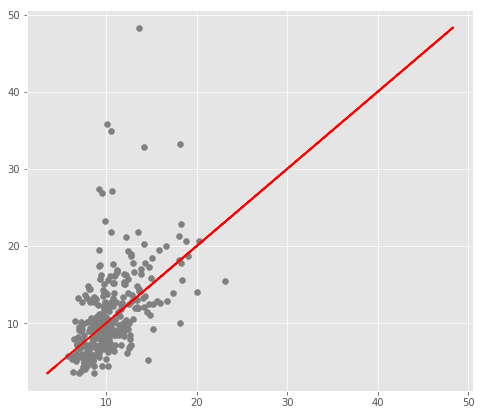

In [33]:
get_plot(y_pred_ridge_volatility, y_test_volatility)

In [34]:
# B.3 Lassooo
model_lasso_volatility = linear_model.Lasso()
model_lasso_volatility.fit(x_train_volatility, y_train_volatility)

y_pred_lasso_volatility = model_lasso_volatility.predict(x_test_volatility)
get_performance(y_pred_lasso_volatility, y_test_volatility)

Mean Absolute Error: 3.1544
Mean Squared Error: 24.6419
Root Mean Squared Error: 4.9641


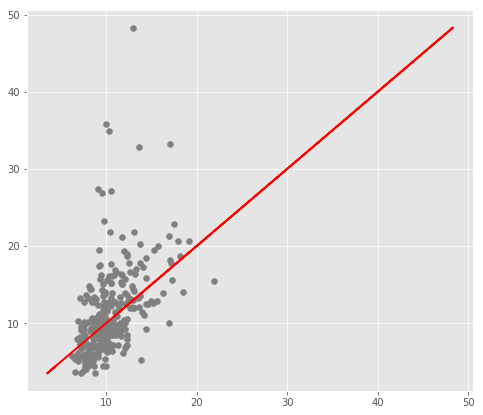

In [35]:
get_plot(y_pred_lasso_volatility, y_test_volatility)

In [103]:
## Compare Feature C to the baseline:

x_train_mav = X_mav[:mav_split]
y_train_mav = Y_mav[:mav_split]

x_test_mav = X_mav[mav_split:]
y_test_mav = Y_mav[mav_split:]

# C.1 Linear Regression
model_lr_mav = linear_model.LinearRegression()
model_lr_mav.fit(x_train_mav, y_train_mav)

y_pred_lr_mav = model_lr_mav.predict(x_test_mav)
get_performance(y_pred_lr_mav, y_test_mav)

Mean Absolute Error: 14.5768
Mean Squared Error: 352.1531
Root Mean Squared Error: 18.7657


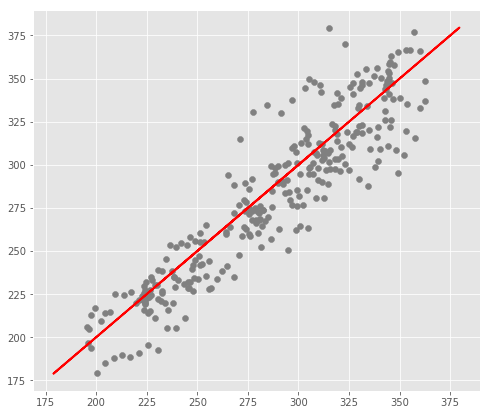

In [104]:
get_plot(y_pred_lr_mav, y_test_mav)

In [105]:
# C.2 Ridge Regression
model_ridge_mav = linear_model.Ridge()
model_ridge_mav.fit(x_train_mav, y_train_mav)

y_pred_ridge_mav = model_ridge_mav.predict(x_test_mav)
get_performance(y_pred_ridge_mav, y_test_mav)

Mean Absolute Error: 14.5768
Mean Squared Error: 352.1532
Root Mean Squared Error: 18.7657


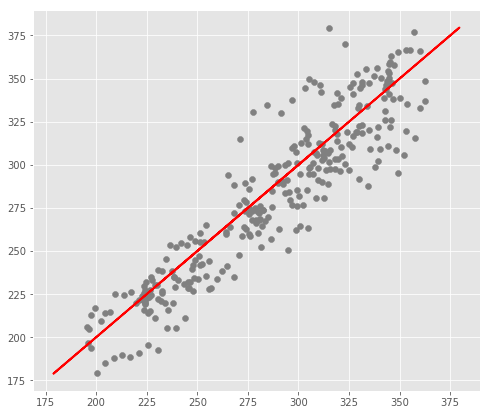

In [106]:
get_plot(y_pred_ridge_mav, y_test_mav)

In [107]:
# C.3 Lassooo
model_lasso_mav = linear_model.Lasso()
model_lasso_mav.fit(x_train_mav, y_train_mav)

y_pred_lasso_mav = model_lasso_mav.predict(x_test_mav)
get_performance(y_pred_lasso_mav, y_test_mav)

Mean Absolute Error: 14.5777
Mean Squared Error: 352.1681
Root Mean Squared Error: 18.7661


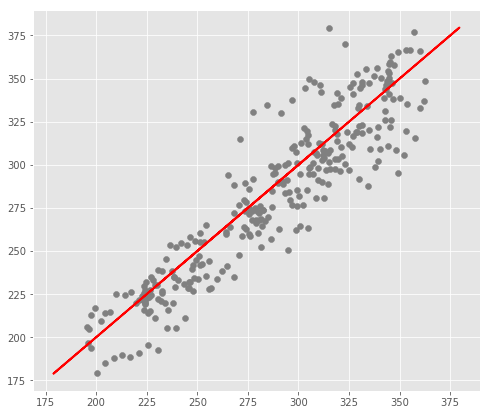

In [108]:
get_plot(y_pred_lasso_mav, y_test_mav)

In [109]:
## Compare Feature D to the baseline

x_train_pretrades = X_pretrades[:pretrades_split]
y_train_pretrades = Y_pretrades[:pretrades_split]

x_test_pretrades = X_pretrades[pretrades_split:]
y_test_pretrades = Y_pretrades[pretrades_split:]

# D.1 Linear Regression
model_lr_pretrades=linear_model.LinearRegression()
model_lr_pretrades.fit(x_train_pretrades, y_train_pretrades)

y_pred_lr_pretrades = model_lr_pretrades.predict(x_test_pretrades)
get_performance(y_pred_lr_pretrades, y_test_pretrades)

Mean Absolute Error: 375.7327
Mean Squared Error: 148990.255
Root Mean Squared Error: 385.9926


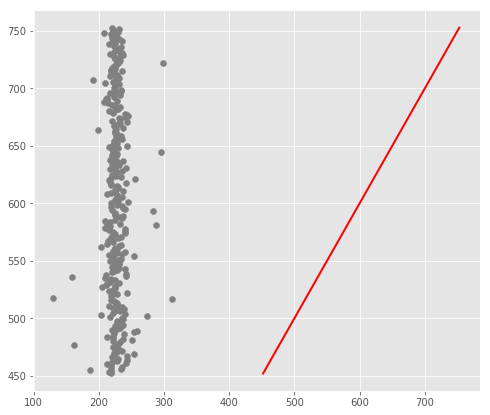

In [41]:
get_plot(y_pred_lr_pretrades, y_test_pretrades)

In [42]:
# D.2 Ridge
model_ridge_pretrades = linear_model.Ridge()
model_ridge_pretrades.fit(x_train_pretrades, y_train_pretrades)

y_pred_ridge_pretrades = model_ridge_pretrades.predict(x_test_pretrades)
get_performance(y_pred_ridge_pretrades, y_test_pretrades)

Mean Absolute Error: 375.7329
Mean Squared Error: 148990.3321
Root Mean Squared Error: 385.9927


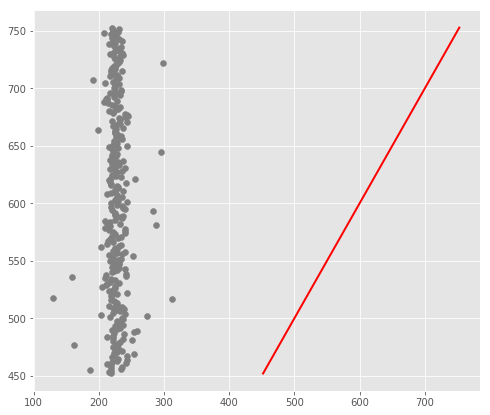

In [43]:
get_plot(y_pred_ridge_pretrades, y_test_pretrades)

In [44]:
# D.3 Lasso
model_lasso_pretrades = linear_model.Lasso()
model_lasso_pretrades.fit(x_train_pretrades, y_train_pretrades)

y_pred_lasso_pretrades = model_lasso_pretrades.predict(x_test_pretrades)
get_performance(y_pred_lasso_pretrades, y_test_pretrades)

Mean Absolute Error: 375.7709
Mean Squared Error: 149005.459
Root Mean Squared Error: 386.0123


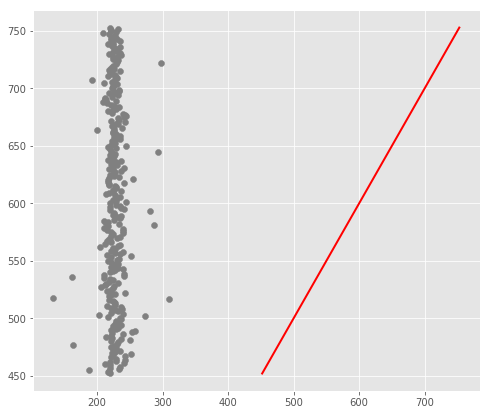

In [45]:
get_plot(y_pred_lasso_pretrades, y_test_pretrades)